# 0. 모델링 코드 실행 전 준비사항

1. 음성 파일(real,fake)을 압축한 하나의 압축파일을 구글 드라이브에 업로드
  

2. 구글 드라이브 마운트

3. 압축파일 풀기
  - 실행 전 경로 수정하기
  - 파일명과 폴더명은 fake 또는 real이 포함되어야 한다

In [ ]:
# 1. 압축 파일 업로드
# real 음성과 fake 음성을 업로드


# 2.구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 3. 압축파일 풀기
!unzip -qq /content/drive/MyDrive/team_test/data200_refin.zip -d /content/drive/MyDrive/team_test/data200_refin

# 1. 데이터 로드

1. 모듈 import
2. 각 파일의 경로가 담긴 리스트 생성

In [ ]:
# 1. 필요한 모듈 import
%%time
import pandas as pd
import numpy as np
from glob import glob 
import tensorflow as tf  # TensorFlow 2.0 
import random

# ※ 모든 무작위 값을 대비하기 위해 seed 값 지정
tf.random.set_seed(777)
np.random.seed(777)
random.seed(777)

CPU times: user 3.2 s, sys: 443 ms, total: 3.65 s
Wall time: 3.68 s


In [ ]:
# 2. 각 파일의 경로가 담긴 리스트 생성
# 압축풀기로 생성된 폴더의 경로
File_root = glob.glob('/content/drive/MyDrive/team_test/data200_refin')[0]


# 폴더 하위에 있는 fake, real 폴더에서 각 파일의 경로를 리스트(X_path)에 담기
X_path = glob.glob(File_root + "/fake/*")
X_path = X_path + glob.glob(File_root + "/real/*")   # * 는 모두 가져오라  

len(X_path)   # 전체 음성 파일 개수 확인 : 392

392

# 2. 정답 배열 만들기

1. 빈 numpy array 생성
2. 배열을 생성하는 for 문
  : 파일 경로에서 정답정보(fake 또는 real)를 찾아 0 또는 1이 추가됨
    - real : 0 / fake :1 

In [ ]:
import ntpath 

# 1. 빈 numpy array 생성
y = np.empty((0, 1, ))

# 2. for문 
for f in X_path: 
    if 'real' in ntpath.basename(f):
        resp = np.array([0])  #   [0]
        resp = resp.reshape(1, 1, )  # 2차원으로 만듦
        y = np.vstack((y, resp))     # 배열을 세로로 append 
    elif 'fake' in ntpath.basename(f):
        resp = np.array([1])  # [1] 
        resp = resp.reshape(1, 1, ) #[[1]]
        y = np.vstack((y, resp)) 

# 정답 배열 확인
# print (y)

# 3. 훈련과 테스트 데이터 분할

In [ ]:
# 훈련과 테스트 나누기 (validation data 까지 3개의 데이터 생성)
%%time

from sklearn.model_selection import train_test_split

# ※ 모든 무작위 값을 대비하기 위해 seed 값 지정
tf.random.set_seed(777)
np.random.seed(777)
random.seed(777)

X_train, X_test, y_train, y_test = train_test_split(X_path, y, test_size = 0.1, random_state = 777, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.05, random_state = 777, stratify = y_train)

dictionary = {
    'X_train': X_train,
    'X_test': X_test,
    'X_val': X_val,
    'y_train': y_train,
    'y_test': y_test,
    'y_val': y_val
}

#훈련, 테스트, 검증 데이터 양 검사
for str_idx, data in dictionary.items():
    print('%s Data: %d(%.1f%%)'%(str_idx, len(data), (len(data) / len(y) * 100 )))



# 데이터 인덱스번호와 경로 담는 딕셔너리
train_path={}
for idx, i in enumerate(X_train):
  train_path[idx]=i
  # print(idx, i)

test_path={}
for idx, i in enumerate(X_test):
  test_path[idx]=i
  # print(idx, i)

val_path={}
for idx, i in enumerate(X_val):
  val_path[idx]=i
  # print(idx, i)


X_train Data: 352(89.8%)
X_test Data: 40(10.2%)
y_train Data: 352(89.8%)
y_test Data: 40(10.2%)
CPU times: user 72.6 ms, sys: 10.9 ms, total: 83.5 ms
Wall time: 235 ms


In [ ]:
# 데이터 확인
import IPython.display as ipd
ipd.Audio(X_test[21])  

# 4. 데이터 변환1

1. librosa_read_wave_files 함수 생성
  : 각 파일의 진폭값을 리스트 형태로 반환하는 함수

2. 각 class(real, fake)의 sample_rate 생성
  - ★ 각 클래스에 대해 다른 sample_rate 사용할 지는 모델링 결과 확인 또는 논의 필요

3. X_train, X_test 생성(X_train,X_test 다른 값으로 갱신됨)
  - librosa_read_wave_files 함수 사용

In [ ]:
# 0. librosa import
import librosa

# 1. librosa_read_wave_files 함수 생성
def librosa_read_wav_files(wav_files):
    if not isinstance(wav_files, list): 
        wav_files = [wav_files]  
    return [librosa.load(f)[0] for f in wav_files]        
           
  # librosa.load(f) : 음원의 숫자값(진폭), sr값 반환
  # librosa.load(f)[0] : 진폭

In [ ]:
# 2. 각 class(real, fake)에 대해 사용할 sample_rate 생성
wav_rate = librosa.load(X_train[0])[1]    # sr값

In [ ]:
# 3. X_train, X_test 생성(X_train,X_test 다른 값으로 갱신)
X_train = librosa_read_wav_files(X_train)  
X_test  = librosa_read_wav_files(X_test)
X_val  = librosa_read_wav_files(X_val)

# 갱신된 X_train, X_test 개수, 형태 확인
print(len(X_train))
print(len(X_test))
print(len(X_val))

print(X_train[0])

352
40
[1.4424678e-04 2.2163136e-04 6.3644140e-05 ... 7.8659572e-02 9.0862542e-02
 0.0000000e+00]


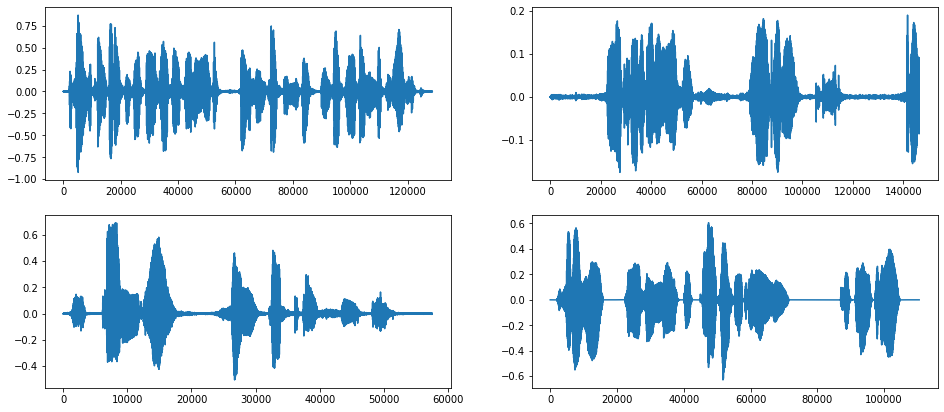

In [ ]:
# 시각화해서 확인하기
# real 음성과 fake 음성 시각화
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(16,7))

# real
axs[0][0].plot(X_train[1])   
axs[0][1].plot(X_train[0])   

# fake
axs[1][0].plot(X_train[6])   
axs[1][1].plot(X_train[21])  
plt.show()

# 5. 데이터 변환2 : MFCC

1. extract_features 함수 생성
  : 음성에서 41개의 특징을 추출하는 함수

2. X_train_features, X_test_features 생성
  - extract_features 함수 사용
  - 각 음성 데이터에 대해 41개의 features 생성하여 배열에 담은 것을 객체화

In [ ]:
# 1. extract_features 함수 생성
def extract_features(audio_samples, sample_rate):   #  숫자값, 주파수 대역 숫자를 받는 함수

    # 비어있는 numpy list생성(각 음성 당 41개의 특징 받을 예정)
    extracted_features = np.empty((0, 41, )) # 41개의 값을 받을 메모리를 할당
    if not isinstance(audio_samples, list):# 리스트가 아니라면 리스트화
        audio_samples = [audio_samples]

    # ★ audio_samples => X_train, X_test
    for sample in audio_samples:
        # 음성에서 추출한 특징 41개 중 zero_crossing  데이터 구하기
        zero_cross_feat = librosa.feature.zero_crossing_rate(sample).mean() 
        
        # 주파수 스펙트럼 데이터 40개를 준비(40개의 대역에서 추출)
        # ★ sample_rate => wave_rate
        # n_mfcc는 100개까지 가능
        mfccs = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=40) 
        
        # 전치 시켜서 각 주파수별 평균값 구함
        mfccsscaled = np.mean(mfccs.T,axis=0) 
        mfccsscaled = np.append(mfccsscaled, zero_cross_feat)
        mfccsscaled = mfccsscaled.reshape(1, 41, )
        
        # 비어있는 numpy array 인 extracted_features에 41개의 요소를 추가
        # 41개 = 주파수 스펙트럼 데이터 40개 + zero_crossing 데이터 1개
        extracted_features = np.vstack((extracted_features, mfccsscaled))
    return extracted_features

In [ ]:
# 2. X_train_features, X_test_features 생성
X_train_features = extract_features(X_train, wav_rate) 
X_test_features  = extract_features(X_test, wav_rate)
X_val_features  = extract_features(X_val, wav_rate)

print(len(X_train_features))   # = len(X_train)
print(len(X_test_features))    # = len(X_test)
print(len(X_val_features))    # = len(X_test)

352
40


# 6. 정답 배열 one-hot encoding

1. 신경망을 위한 패키지 준비
2. one-hot encoding 으로 정답 객체화(train_labels, test_labels)
  - 신경망에 사용되기 위해서는 one-hot encoding되어야 한다

In [ ]:
# 1 신경망을 위한 패키지 준비
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import to_categorical


## random
tf.random.set_seed(777)
np.random.seed(777)
random.seed(777)

# 2. one-hot encoding
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)
val_labels = to_categorical(y_val)

# 확인|
print(test_labels)
# print(val_labels)

 # 출력예시
# [1. 0.]
# [0. 1.]
# [1. 0.]

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


# for 문으로 파라미터 개선

In [ ]:
# parameter 들이 중복순열로 조합으로 params에 들어옴

# (하이퍼 파라미터, 훈련 데이터, 훈련 데이터 정답, 테스트 데이터, 테스트 데이터 정답, 검증 데이터, 검증 데이터 정답)
def create_model(params, X_train_features, train_labels, X_test_features, test_labels, X_val_features, val_labels):
    ## 신경망 모델을 구성하기 위한 패키지 로드
    from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
    from keras import models
    from keras import optimizers
    from keras import losses
    from keras.callbacks import ModelCheckpoint, EarlyStopping
    from tqdm.notebook import tqdm
    import pandas as pd
    from time import time
    from datetime import timedelta, datetime
    import os
    
    # 훈련시키는 과정에서 정확도가 상승되는지에 대해서만 집중하고 싶다면
    import absl.logging    # 오류창 무시  -> future warning과 같은 불필요한 오류창 
    absl.logging.set_verbosity(absl.logging.ERROR)

    ## 저장 변수 선언
    result1 = []   # 훈련, 테스트, 검정 데이터 오차, 정확도외 많은 정보를 담을 리스트 

    train_acc_list = []
    train_loss_list = []

    vali_acc_list = []
    vali_loss_list = []
    
    now = datetime.now() # 파일명에 시간을 기록하기 위해 선언하는 변수   -> 최종으로 생성되는 엑셀파일의 파일명으로 사용됨

# ############### Hyper parameters ################

# activation = ['ReLU','sigmoid','tanh']  # 활성화 함수
# gradient = ['Adam','RMSProp','Adagrad'] # 경사하강법
# patiences = [15]       # EarlyStopping 활성화 시 기준되는 값이 연속으로 몇 번 이상 향상되지 않을 때 종료시킬 변수 값
# epochs = [200]         # epochs
# batch_size = [50]      # batch_size(사용 안할 시 None으로 지정)
# neurons = [150]        # 은닉층 뉴런 수
# layers = [3]           # 은닉층 수
# neu_div_rate = [1, 0.9]   # 뉴런 수 감소 비율, 드롭아웃 외에 오버피팅을 조금이라도 더 줄이기 위해
# batchnorm = [True]     # 배치 정규화 활성화 여부
# dropout = [0.2]        # 드랍아웃 비율
# chk_point = [True]     # check point 활성화 여부, 훈련 중간에 모니터링 하면서 모델을 에폭마다 저장할지
                          # 이게 활성화 되어야 해당 하이퍼 파라미터로 만들어진 모델을 사용할 수 있다.
# early_stop = [True]    # Early Stopping 기능 활성화 여부

# ★★ 추가 
# seed = [777]

# #################################################

    ## 모든 hyper parameter를 고려하여 반복문 실행

                                                                          # tqdm -> for문 진행과정 보여줌
    for act, grad, pat, epo, bat, neu, lyr, nudir, bctn, drp, chkp, erstp,sd in tqdm(params, desc = 'Progress... '):
        temp1 = neu     # 은닉층 뉴런수 
        temp2 = [] # 은닉층 뉴런 수 저장 변수

        start = time()

        ## 완전 연결계층으로 다층 신경망 구성
        # ※ 모든 무작위 값을 대비하기 위해 seed 값 지정
        tf.random.set_seed(sd)
        np.random.seed(sd)
        random.seed(sd)

        model = models.Sequential()
        model.add(Flatten(input_shape = (41, ))) # 입력층

        # 하이퍼 파라미터에 맞춰 모델 구성하는 부분
        for _ in range(lyr):                                  # 층 개수만큼 반복
            model.add(Dense(temp1, activation = act)) # 은닉층    # temp1 = nue = 처음 뉴런의 수

            if bctn:  # batchnorm이 True 이면
                model.add(BatchNormalization()) # 배치 정규화 추가

            model.add(Dropout(drp)) 
            temp2.append(temp1)       
            temp1 = int(temp1 * nudir)

        model.add(Dense(2, activation = 'softmax')) # 출력층
        # print(model.summary()) # 현 모델 요약 표시(비활성화)

        
        # 중간중간 모델이 모두 저장되게
        model_path = "/content/drive/MyDrive/team_test/for_test/{epoch:04d}"      #(pb파일형태 : 모델 + 가중치)

        if chkp: # 체크 포인트 사용시
            checkpoint = ModelCheckpoint(
                model_path, 
                monitor = 'val_accuracy',  # 테스트 데이터에 대한 정확도를 기준으로 하여 가장 좋은 것으로 측정
                save_best_only = True,     # monitor 되고 있는 것 중에 가장 좋은 모델을 저장
                mode = 'max',              # monitor를 val_acc(정확도)로 했으면 클 수록 좋으므로 max로 설정하고 val_loss(오차)로 했으면 min으로 설정하는 것이 좋음
                save_weights_only = False, # 모델 레이어 및 weights 모두 저장
                verbose = 1,               # 모델이 저장되었으면 저장되었다고 표시(1), 표시 비활성화(0)
                # period = 1 # default로 수행하는 것이 효율이 좋았음
            )

        else:
            checkpoint = False

        if erstp: # Early Stopping 사용시
            estop = EarlyStopping(monitor = 'val_accuracy', patience = pat, verbose = 0) # EarlyStopping 기능(verbose = 1 → epochs 정지 표시)
            pat = int(pat)

        else:
            estop = False
            pat = None

        # 콜백 정의
        callbacks = [i for i in [checkpoint, estop] if i]
        print(callbacks)

        ## 모델 설정(경사하강법, 오차함수를 정의)
        model.compile(
            optimizer = grad,
            loss = losses.categorical_crossentropy,
            metrics = ['accuracy'],
        )

        ## 모델 훈련
        hist = model.fit(
            X_train_features,
            train_labels,
            validation_data = (X_val_features, val_labels),
            epochs = epo,
            batch_size = bat,
            verbose = 0,
            callbacks = callbacks,
        )

        end = time()
        sec = (end - start)

        time_result = str(timedelta(seconds = sec)).split(".")[0]

        train_loss, train_acc = model.evaluate(X_train_features, train_labels, verbose = 0)
        test_loss, test_acc   = model.evaluate(X_test_features, test_labels, verbose = 0)
        val_loss, val_acc     = model.evaluate(X_val_features, val_labels, verbose = 0)

        # 검증하여 출력한 최종 값
        train_acc_list.append(hist.history['accuracy']) # 훈련 데이터 정확도
        train_loss_list.append(hist.history['loss'])    # 훈련 데이터 오차율
        vali_acc_list.append(hist.history['val_accuracy']) # 검증 데이터 정확도
        vali_loss_list.append(hist.history['val_loss'])    # 검증 데이터 오차율

        final_epochs = len(train_acc_list[-1])

        result1.append((
            train_loss, train_acc, 
            test_loss, test_acc, 
            val_loss, val_acc,
            act, grad, pat, epo, bat,
            final_epochs, temp2, lyr, nudir, bctn, 
            drp, chkp, erstp, sd, time_result
        ))

    result2 = pd.DataFrame(result1)
    result2.columns = [
        'Train Loss', 'Train Accuracy', 
        'Test Loss','Test Accuracy', 
        'Progress Valid Loss', 'Progress Valid Accuracy',
        'Activation', 'Gradient', 'Patience', 'Epochs', 'Batch Size',
        'Final Epochs', 'Neurons', 'Layers', 'Neurons Divide Rate', 'Batch Normalization', 
        'Dropout Rate', 'Check Point', 'Early Stopping', 'Seed','Time'
    ]

    # csv 경로지정
    path1 =  "/content/drive/MyDrive/team_test/for_test/csv" 

    file_list = os.listdir(path1)
    file_name = "%s_result.csv"%(now.strftime("%Y-%m-%d")) # 현재 날짜 저장

    path2 = "%s/%s"%(path1, file_name)

    if file_name in file_list: # 해당 경로의 파일 검사
        result2.to_csv(path2, mode = 'a', header = False, index = True) # 파일이 있을 시 이어쓰기로 표 저장
    else:
        result2.to_csv(path2, mode = 'a', index = True) # 파일이 없을 시 최초 생성

    return result1, result2, train_acc_list, train_loss_list, vali_acc_list, vali_loss_list, model

In [ ]:
######################################################## 아래의 조건을 바꿔 for 문을 실행해본다

################ Hyper parameters ################

activation = ['ReLU','sigmoid','tanh']  # 활성화 함수
gradient = ['RMSProp','adam','Adagrad'] # 경사하강법
epochs = [300]         # epochs
batch_size = [50]      # batch_size(사용 안할 시 None으로 지정)
neurons = [800,700,600,260]        # 은닉층 뉴런 수
layers = [2,3,4,6,8]           # 은닉층 수
neu_div_rate = [1, 0.95,0.5]   # 뉴런 수 감소 비율
batchnorm = [True]     # 배치 정규화 활성화 여부
dropout = [0.2]        # 드랍아웃 비율
patiences = [50]       # EarlyStopping 활성화 시 기준되는 값이 연속으로 몇 번 이상 향상되지 않을 때 종료시킬 변수 값
chk_point = [True]     # check point 활성화 여부
early_stop = [True]    # Early Stopping 기능 활성화 여부
seed = [777]                        # 모델 생성 시의 seed 값

##################################################

## 중복순열을 이용하여 모든 경우의 수 계산하여 tuple에 담음
from itertools import product

params = tuple(product(activation, gradient, patiences, epochs, batch_size, neurons, layers, neu_div_rate, batchnorm, dropout, chk_point, early_stop,seed))
res1, res2, train_acc, train_loss, vali_acc, vali_loss, model = create_model(params, X_train_features, train_labels, X_test_features, test_labels, X_val_features, val_labels)
res2

In [ ]:
# 각 데이터에 대한 loss, accuracy 확인
train_loss, train_acc = model.evaluate(X_train_features, train_labels, verbose = 0)
test_loss, test_acc   = model.evaluate(X_test_features, test_labels, verbose = 0)
val_loss, val_acc     = model.evaluate(X_val_features, val_labels, verbose = 0)

print(train_loss,train_acc)
print(test_loss,test_acc)
print(val_loss,val_acc)

# 모델의 데이터 예측 결과 확인해보기

In [ ]:
false = []   # 예측 틀림
outlier =[]  # 맞았지만 정확도 낮음

ans = { 0 : 'real', 1: 'fake'}

for i in range(40):
  nr_to_predict = i
  print(i)
  pred = model.predict(X_test_features[nr_to_predict].reshape(1, 41,))

  result = list(pred[0]) # 예측 결과 확률 리스트
  max_value = max(result)
  max_idx = result.index(max_value)
  pred_res = ans[max_idx]    # 예측 결과 real 또는 fake

  # 정답
  ans_idx = y_test[i][0]   # 0 또는 1 

  if max_idx != y_test[i]:
    false.append(i)
    print(f'★★★★★★★★ {i} 번 틀림★★★★★★★★★★★★')
    print("real: {} fake: {} ".format(result[0], result[1]))
    print('정답 :',ans[ans_idx])

  elif (max_idx == y_test[i])& (abs(pred[0][0] - pred[0][1]) <=0.5) :
    outlier.append(i)
    print(f'☆☆☆☆☆☆☆☆☆{i} 번 주의☆☆☆☆☆☆☆☆☆')
    print("real: {} fake: {} ".format(result[0], result[1]))
    print('정답 :',ans[ans_idx])

 # 2. 틀리거나 정확도 낮은 인덱스번호 확인
print(len(outlier))
print(outlier)

print(len(false))
print(false)

# 3. 인덱스 번호에 해당하는 경로를 가져오는 코드
for i in outlier:
  print(i,test_path[i])

for i in false:
  print(i,test_path[i])


# 4. 해당 파일을 다른 경로로 옮겨두는 코드 
# !mv /content/drive/MyDrive/team_test/200_test/fake/fake_24.wav /content/drive/MyDrive/team_test/200_test/

# 최종 모델 코드

  - for문으로 찾을 최적의 하이퍼 파라미터로 모델 생성

## 1. 데이터 분할

In [ ]:
# 훈련과 테스트 나누기
%%time

from sklearn.model_selection import train_test_split

# ※ 모든 무작위 값을 대비하기 위해 seed 값 지정
tf.random.set_seed(777)
np.random.seed(777)
random.seed(777)

X_train, X_test, y_train, y_test = train_test_split(X_path, y, test_size = 0.1, random_state = 777, stratify = y)


dictionary = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

#훈련, 테스트 데이터 양 검사
for str_idx, data in dictionary.items():
    print('%s Data: %d(%.1f%%)'%(str_idx, len(data), (len(data) / len(y) * 100 )))



# 데이터 인덱스번호와 경로 담는 딕셔너리
train_path={}
for idx, i in enumerate(X_train):
  train_path[idx]=i
  # print(idx, i)

test_path={}
for idx, i in enumerate(X_test):
  test_path[idx]=i
  # print(idx, i)

## 2. 데이터 전처리1

In [ ]:
# 0. librosa import
import librosa

# 1. librosa_read_wave_files 함수 생성
def librosa_read_wav_files(wav_files):
    if not isinstance(wav_files, list): 
        wav_files = [wav_files]  
    return [librosa.load(f)[0] for f in wav_files]        
           
# 2. 각 class(real, fake)에 대해 사용할 sample_rate 생성
wav_rate = librosa.load(X_train[0])[1]    # sr값

# 3. X_train, X_test 생성(X_train,X_test 다른 값으로 갱신)
X_train = librosa_read_wav_files(X_train)  
X_test  = librosa_read_wav_files(X_test)

# 갱신된 X_train, X_test 개수, 형태 확인
print(len(X_train))
print(len(X_test))


print(X_train[0])

## 3. 데이터 전처리3

In [ ]:
# 1. extract_features 함수 생성
def extract_features(audio_samples, sample_rate):   #  숫자값, 주파수 대역 숫자를 받는 함수

    # 비어있는 numpy list생성(각 음성 당 41개의 특징 받을 예정)
    extracted_features = np.empty((0, 41, )) # 41개의 값을 받을 메모리를 할당
    if not isinstance(audio_samples, list):# 리스트가 아니라면 리스트화
        audio_samples = [audio_samples]

    # ★ audio_samples => X_train, X_test
    for sample in audio_samples:
        # 음성에서 추출한 특징 41개 중 zero_crossing  데이터 구하기
        zero_cross_feat = librosa.feature.zero_crossing_rate(sample).mean() 
        
        # 주파수 스펙트럼 데이터 40개를 준비(40개의 대역에서 추출)
        # ★ sample_rate => wave_rate
        # n_mfcc는 100개까지 가능
        mfccs = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=40) 
        
        # 전치 시켜서 각 주파수별 평균값 구함
        mfccsscaled = np.mean(mfccs.T,axis=0) 
        mfccsscaled = np.append(mfccsscaled, zero_cross_feat)
        mfccsscaled = mfccsscaled.reshape(1, 41, )
        
        # 비어있는 numpy array 인 extracted_features에 41개의 요소를 추가
        # 41개 = 주파수 스펙트럼 데이터 40개 + zero_crossing 데이터 1개
        extracted_features = np.vstack((extracted_features, mfccsscaled))
    return extracted_features


# 2. X_train_features, X_test_features 생성
X_train_features = extract_features(X_train, wav_rate) 
X_test_features  = extract_features(X_test, wav_rate)


print(len(X_train_features))   # = len(X_train)
print(len(X_test_features))    # = len(X_test)

##4. 정답 생성

In [ ]:
# 1 신경망을 위한 패키지 준비
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import to_categorical


## random
tf.random.set_seed(777)
np.random.seed(777)
random.seed(777)

# 2. one-hot encoding
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

# 확인
print(test_labels)

## 5. 모델 생성

In [ ]:
# 1 신경망을 위한 패키지 준비
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization

## random
tf.random.set_seed(777)
np.random.seed(777)
random.seed(777)

# 1. 완전 연결 계층 모델 구성(for문 테스트)
model = models.Sequential()
model.add(Flatten(input_shape = (41, ))) # 입력층

model.add(Dense(260, activation = 'tanh'))
model.add(BatchNormalization()) # 배치 정규화 추가
model.add(Dropout(0.2))

model.add(Dense(260, activation = 'tanh'))
model.add(BatchNormalization()) # 배치 정규화 추가
model.add(Dropout(0.2))

model.add(Dense(2, activation = 'softmax'))

model_path = "/content/drive/MyDrive/team_test/for_test_chk/{epoch:04d}"   # 모델이 모두 저장되게

checkpoint = ModelCheckpoint(
                model_path, 
                monitor = 'val_accuracy',  
                save_best_only = True,    
                mode = 'max',            
                save_weights_only = False, 
                verbose = 1,              
            )


estop = EarlyStopping(monitor = 'val_accuracy', patience = 50, verbose = 0)
callbacks = [checkpoint, estop]

model.compile(optimizer='adam',
              loss=losses.categorical_crossentropy,
              metrics=['accuracy'])


# 3. 모델 훈련
history = model.fit(
    X_train_features,   # 훈련 데이터
    train_labels,     # 훈련 데이터의 라벨(정답)
    validation_data=(X_test_features,test_labels),  # 테스트 데이터와 정답
    epochs = 33,
    verbose = 1,
    callbacks=callbacks  # 얼리스탑 기능 구현을 위해서 위에서 만든 callbacks 지정
)

In [ ]:
# 훈련과 테스트 데이터 정확도 확인
train_loss, train_acc = model.evaluate(X_train_features, train_labels, verbose = 0)
test_loss, test_acc   = model.evaluate(X_test_features, test_labels, verbose = 0)


print(train_loss,train_acc)
print(test_loss,test_acc)

0.09235101193189621 0.96875
0.4796361029148102 0.925000011920929


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


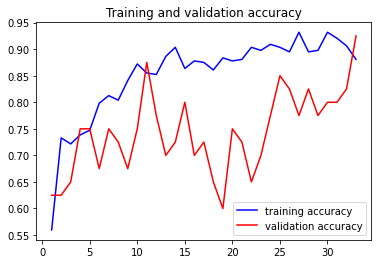

In [ ]:
# 학습 과정 시각화
import matplotlib.pyplot as plt
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'b', label = "training accuracy")
plt.plot(epochs, val_acc, 'r', label = "validation accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

### FN값, 정확도 확인

In [ ]:
# 테스트 데이터 예측 값(1,0)을 만드는 코드
result = []
for i in X_test_features:
  pred = model.predict(i.reshape(1, 41,))[0]
  pred2 = np.argmax(pred)
  result.append(pred2)


test_label =[]
for i  in  test_labels:
  a= np.argmax(i)
  test_label.append(a)


# 모델 평가
# 정확도 확인
accuracy = (sum(np.array(result) == np.array(test_label))/len(test_label))*100
print('accuracy:', accuracy) 


# FN 값 확인
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test,result).ravel()
print(tn,fp,fn,tp)

1/1 [==============================] - 0s 19ms/step
accuracy: 92.5
20 0 3 17


In [ ]:
### 카파통계량
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_test,result)                                

#  민감도와 특이도
from sklearn.metrics import confusion_matrix

tn, fp,fn,tp = confusion_matrix(y_test,result).ravel()
print(f'tn,fp,fn,tp : {tn,fp,fn,tp}')

accuacy = (tn+tp)/(tn+fp+tn+tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

# 정밀도
precision = tp/(tp+fp)

print(f'kappa : {kappa}')
print(f'accuracy : {accuracy}')
print(f'sensitivity(민감도,재현율) : {sensitivity}')
print(f'specificity : {specificity}')
print(f'precision : {precision}')

tn,fp,fn,tp : (20, 0, 3, 17)
kappa : 0.85
accuracy : 92.5
sensitivity(민감도,재현율) : 0.85
specificity : 1.0
precision : 1.0


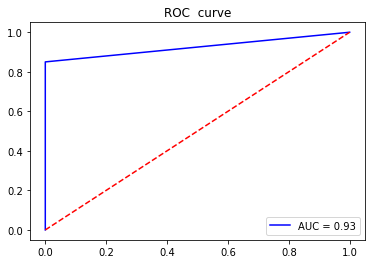

In [ ]:
# AUC 구하기 
from  sklearn  import  metrics

fpr, tpr , threshold  = metrics.roc_curve( y_test, result )
roc_auc = metrics.auc( fpr, tpr )
roc_auc  # 0.925

# ROC 곡선 그리기
import  matplotlib.pyplot  as  plt
plt.title("ROC  curve")
plt.plot( fpr, tpr , 'blue', label='AUC = %0.2f' % roc_auc )
plt.legend( loc = 'lower right')

plt.plot([0,1], [0,1], 'r--') 
plt.show()

In [ ]:
# 모델 가중치와 모델 저장

model.save_weights('/content/drive/MyDrive/rnn/final_model/model_wieghts_final.h5')
model.save('/content/drive/MyDrive/rnn/final_model/voice_model_final.h5')

In [ ]:
# f1_score 
f1_score = (2*(precision*sensitivity))/(precision + sensitivity)
print(f1_score)

0.9189189189189189
